In [1]:
import spacy
!python -m spacy download en_core_web_md
import en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [2]:
nlp = en_core_web_md.load()
type(nlp)

spacy.lang.en.English

In [3]:
import pandas as pd
import numpy as np
import matplotlib as plot

In [4]:
tweets = pd.read_csv('clean_twitter_data.csv', index_col = 0)
tweets.shape

(54847, 3)

In [5]:
tweets.head()

,date,text,sentiment
0,2019-05-08 19:21:47,"says connected, shared, electric, and autonomo...",0.4
1,2019-05-08 19:21:39,Anna Golubeva was awarded the prestigious Gill...,0.0
2,2019-05-08 19:20:44,Scientists have developed an system that can d...,0.1
3,2019-05-08 19:20:37,One of the best questions asked today at AI ev...,1.0
4,2019-05-08 19:20:27,Hasso Plattner kicks off day with the increase...,0.0


In [6]:
tweets = tweets[tweets['sentiment'] != 0.0]
tweets.drop_duplicates(inplace=True)
tweets.shape

(25564, 3)

In [7]:
sample = tweets.sample(1000)['text'].tolist()

The sample will be tokenized to perform analysis.

In [8]:
doc_sample = [nlp(tweet) for tweet in sample]

In [9]:
doc_sample[0]

Scientist\xe2\x80\x99s Dilemma: The Cold Start Problem Ten Machine Learning Examples '

In [10]:
type(doc_sample[0])

spacy.tokens.doc.Doc

To obtain list of used words, but without punctuation marks and stop words:

In [11]:
def tokenize(sample):
    all_tokens = []
    for doc in sample:
        for token in doc:
            if token.is_stop == False and token.is_alpha == True:
                all_tokens.append(token.lemma_)
    return all_tokens

In [ ]:
#from IPython.core.debugger import Tracer; Tracer()()

In [12]:
all_tokens = tokenize(doc_sample)

In [13]:
def change_big_letters(old_list):
    new_list=[]
    for element in old_list:
        element = element.casefold()
        new_list.append(element)
    return new_list

In [14]:
all_tokens = change_big_letters(all_tokens)

In [15]:
len(all_tokens) 

6250

To perform simple analysis of words occurance:

In [16]:
from collections import Counter

In [17]:
c = Counter(all_tokens).most_common(20)

In [18]:
counts = pd.DataFrame(c, columns=['word', 'count'])
counts = counts.set_index('word')

In [19]:
counts.head(3)

,count
word,
artificial,245
intelligence,240
ai,147


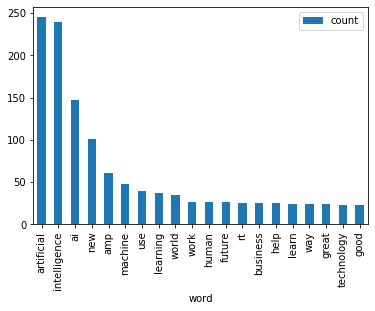

In [21]:
_= counts.plot.bar()

Returning to sentiment analysis - make a column with decision, which is based on value of sentiment.

In [22]:
def sentiment_to_label(sentiment_score):
    if sentiment_score < 0:
        return 0
    else:
        return 1

In [23]:
tweets['sentiment'] = tweets['sentiment'].apply(lambda x: sentiment_to_label(x))

In [24]:
tweets.head()

,date,text,sentiment
0,2019-05-08 19:21:47,"says connected, shared, electric, and autonomo...",1
2,2019-05-08 19:20:44,Scientists have developed an system that can d...,1
3,2019-05-08 19:20:37,One of the best questions asked today at AI ev...,1
5,2019-05-08 19:20:24,"Our Managing Partner, , being interviewed by o...",1
7,2019-05-08 19:19:23,"CHANCE! Read the highly-rated eBook ""The Selli...",0


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
tweets = tweets[['text', 'sentiment']]

In [27]:
tweets.head()

,text,sentiment
0,"says connected, shared, electric, and autonomo...",1
2,Scientists have developed an system that can d...,1
3,One of the best questions asked today at AI ev...,1
5,"Our Managing Partner, , being interviewed by o...",1
7,"CHANCE! Read the highly-rated eBook ""The Selli...",0


In [28]:
tweets.dropna(inplace=True)

Division of the Dataframe into test and train sets.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(tweets['text'], tweets['sentiment'], train_size=0.8, random_state=42)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

Data vectorization, fit_transform() function does two things to data: fits the model and learns the vocabulary; and transforms training data into feature vectors.

The vectorizer is using bag of words method.

In [36]:
vectorizer = CountVectorizer(analyzer = "word",max_features = 5000)

train_data_features = vectorizer.fit_transform(X_train)
train_data_features = train_data_features.toarray()

In [37]:
test_data_features = vectorizer.transform(X_test)
test_data_features = test_data_features.toarray()

In [38]:
clf = LogisticRegression(random_state=42).fit(train_data_features, y_train)

/home/pacis/.local/share/virtualenvs/sentiment-analysis-oKCWBvds/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


clf.score() describes model accuracy, it returns the coefficient of determination R^2 of the prediction.

In [39]:
clf.score(train_data_features, y_train)

0.9935944452594005

In [40]:
predicted_values = clf.predict(test_data_features)

In [41]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report

In [42]:
print(classification_report(predicted_values, y_test))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1635
           1       0.99      0.98      0.99      3478

    accuracy                           0.98      5113
   macro avg       0.98      0.98      0.98      5113
weighted avg       0.98      0.98      0.98      5113



(From muthu.co) 

Recall: fraction of positives that were correctly identified.
Precision: accuracy of positive predictions.

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. 